# Find Similar Faces in CelebA Kaggle Dataset


## Introduction
The following notebook explains how to use ApertureDB's built in similarity search feature. 

The notebook also introduces an interface to ingest data from public datasets available on Kaggle.

Furthermore, it serves as an end to end example for the way in which the following common interactions with a typical DB happen:

1. Data ingestion (and enhancement on the fly)
1. Introduction to ApertureDB Parallel loader
1. Data query based on:
  - metadata (queries like find faces that match a certain criteria)
  - embeddings (aka vector search)


## Prerequisites.
 - Access to an ApertureDB instance.
 - aperturedb-python installed. (note that pytorch and facenet gets pulled in as dependency of aperturedb)
 - Setup the Kaggle API (Refer to [Readme](https://github.com/Kaggle/kaggle-api))


### Install pytorch

In [ ]:
%pip install aperturedb[complete]

### Common imports, definitions and their relavance.

- [facenet](https://github.com/aperture-data/aperturedb-python/blob/main/aperturedb/transformers/facenet.py) : This relies on a [model](https://github.com/timesler/facenet-pytorch) that is used to generate embeddings that are generated when ingesting images from CelebA Dataset.

    ```from aperturedb.transformers.facenet import generate_embedding```

- [CelebADataKaggle](https://github.com/aperture-data/aperturedb-python/blob/main/examples/CelebADataKaggle.py) : This is the traslation layer that converts the images on [CelebA Dataset on kaggle](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset) into the queries that lead to persisting of those set of images and their meta data into ApertureDB. *Along the way, it also **generates embeddings using facenet** that are used to query on the basis of similarity*.

    ```from CelebADataKaggle import CelebADataKaggle```

In [1]:
# Define some common variables.
from aperturedb.transformers.facenet import generate_embedding
from CelebADataKaggle import CelebADataKaggle


search_set_name = "similar_celebreties"

## Data ingestion

### DescriptorSets and Descriptors

DescriptorSets are sets of feature vectors which are extracted using the same algorithm. These are essential building blocks to ensure that the search we intend to perform is 'apples' to 'apples'.

The terms 'Descriptors', 'Feature Vectors', and 'Embeddings' are used interchangeably in the context of the Query language.

For more details on these two ApertureDB concepts, refer to the following links
- [DescriptorSets](/query_language/Reference/descriptor_commands/desc_set_commands/AddDescriptorSet) 
- [Descriptors](/query_language/Reference/descriptor_commands/desc_commands/AddDescriptor)

### Set up a clean slate

In [2]:
from aperturedb.Utils import create_connector, Utils

# Connect to the ApertureDB instance.
con = create_connector()

utils = Utils(con)

# Create a new empty descriptor set.
utils.add_descriptorset(search_set_name, 512,
    metric=["L2"], engine="FaissFlat")

False

### Load Kaggle dataset into ApertureDB.
This step uses a dataset celebA, which is available on Kaggle, and ingests it into ApertureDB.

Also, specifically for the purpose of facilitating similarity search, we use facenet to generate descriptors for all the images of this dataset. 
While ingesting the dataset, the corresponding descriptors are added to the DescriptorSet we created earlier.

For the purpose of explaining the feature, we do not ingest the entire set of images in celebA (which are upwards of 200k), but take in 10000 from there.

[ParallelLoader](/python_sdk/parallel_exec/ParallelLoader) is ApertureDB's mechanism to speed things up. Here is its [source code](https://github.com/aperture-data/aperturedb-python/blob/develop/aperturedb/ParallelLoader.py)

In [3]:
from aperturedb.ParallelLoader import ParallelLoader

# Load the CelebA dataset from Kaggle.
dataset = CelebADataKaggle(
        records_count=10000, # In the interest of time, only pick the first 10k images (of ~200k total)
        embedding_generator=generate_embedding, # use facenet to generate embeddings (ie. descriptors)
        search_set_name=search_set_name
        )
print(len(dataset))

# Ingest from the dataset created previously using a ParallelQuery.
loader = ParallelLoader(create_connector())
loader.ingest(dataset, stats=True)

10000
Progress: 100.00% - ETA(s): 0.65
============ ApertureDB Loader Stats ============
Total time (s): 443.3186671733856
Total queries executed: 10000
Avg Query time (s): 0.007373089671134949
Query time std: 0.004202085272688729
Avg Query Throughput (q/s): 542.5134073249749
Overall insertion throughput (element/s): 22.557137202816946
Total inserted elements: 10000
Total successful commands: 30000


## All of the above (and some more) can be done by executing this through adb cli.
```adb ingest from-generator CelebADataKaggle.py --transformer common_properties --transformer image_properties --transformer clip_pytorch_embeddings --transformer facenet_pytorch_embeddings  --sample-count 10000```

The CLI version of the ingest also does folloing:
- Generate embeddings from another model (CLIP), and facenet models.
- Generates some image related metadata.

.... all while adding this data from kaggle to ApertureDB instance.

## Query examples


### Metadata Search

Here we inspect a sample of the data that has been ingested into ApertureDB.

CelebA Dataset has lots of metadata such as booleans for attributes such as
- Arched_Eyebrows
- Attractive
- Bags_Under_Eyes
- Bald

[Complete list](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset?select=list_attr_celeba.csv)

These attributes are loaded into ApertureDB as image properties which then can be used during search.

Lets search for folks marked as "bald".

Images in the DB = 10000


,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,nose_x,nose_y,partition,righteye_x,righteye_y,rightmouth_x,rightmouth_y,width,x_1,y_1
0,-1,-1,-1,1,1,-1,1,1,-1,-1,...,88,127,0,106,110,103,153,143,194,28
1,-1,-1,-1,1,1,-1,-1,1,-1,-1,...,89,139,0,110,112,113,150,182,221,51
2,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,...,93,140,0,108,110,104,151,78,69,37
3,-1,-1,-1,-1,1,-1,1,1,-1,-1,...,86,133,0,108,111,108,153,114,39,21
4,-1,-1,-1,-1,1,-1,-1,1,-1,-1,...,90,128,0,106,110,104,155,75,124,10


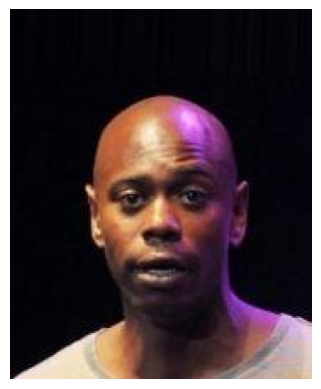

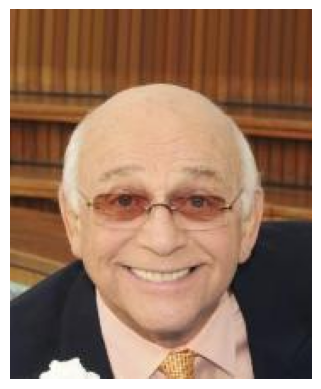

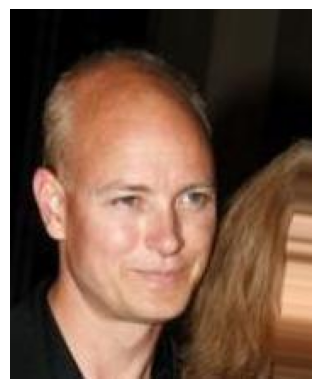

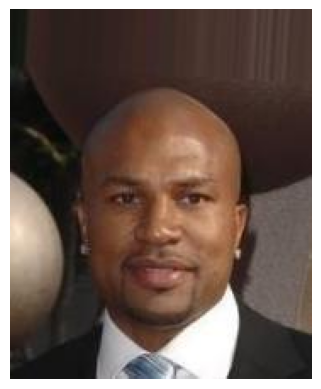

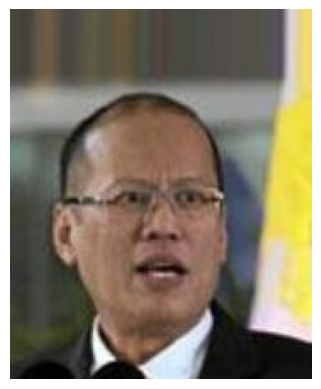

In [4]:
from aperturedb import Images, Utils
import pandas as pd
from aperturedb.Constraints import Constraints

# Connect to ApertureDB.
con = create_connector()
utils = Utils.Utils(con)

print(f"Images in the DB = {utils.count_images()}")

# Find the first 5 images with the 'Bald' attribute
images = Images.Images(con)
images.search(limit=5, constraints=Constraints().equal("Bald", 1))
images.display(show_bboxes=False)

pd.json_normalize(images.get_properties(images.get_props_names()).values())

### Similarity Search

Let's find ingested images that are similar to an image which is not in the dataset. 
For the purpose of this experiment, we're using a publicly available image.

*Fun experiment : Upload your own photo and see which celebries you resemble*

* First, we create a descriptor for using the same algorithm as used for ingestion.
* Next, we perform a nearest-neighbor search to find the 5 descriptors that come closest to our query image.
* Finally, we return the images associated with those 5 nearest neighbor results.

Our database consists of around ~10000 images of people worldwide, which is not that big.
But if this is completely ingested, we should see more relavant matching images.

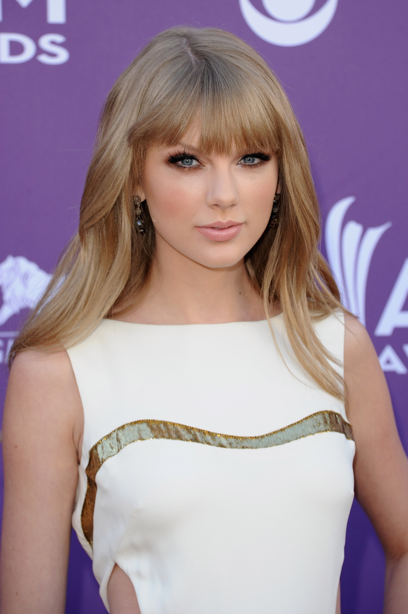

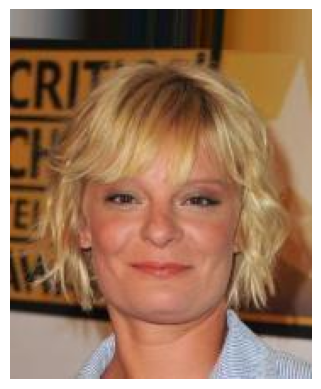

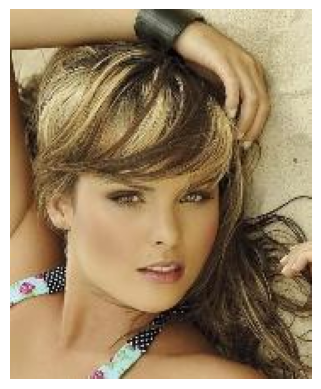

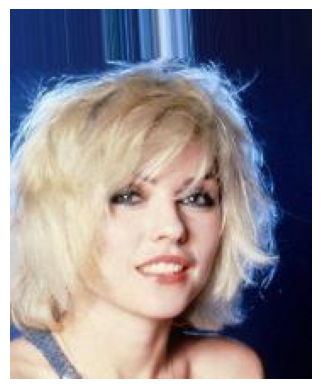

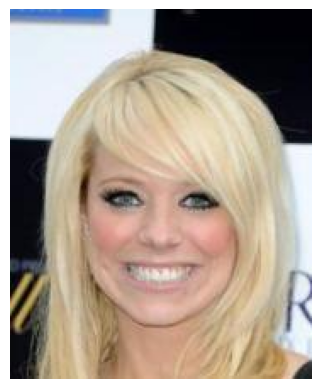

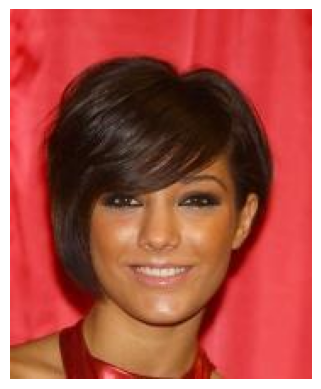

In [5]:
from IPython.display import display
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Pick a query image that is not already in the dataset.
image_name = "taylor-swift.jpg"  # or try with bruce-lee.jpg
pilImage = Image.open(image_name)
display(pilImage.resize((int(pilImage.width * 0.3), int(pilImage.height * 0.3))))

# Generate a descriptor (embedding) from our query image.
embedding = generate_embedding(Image.open(image_name).convert('RGB'))

# This ApertureDB query finds images that are similary to the query image.
q = [{
    # Find descriptors similar to the input descriptor.
    "FindDescriptor": {
        "set": search_set_name, # Search in our CelebA descriptor set.
        "k_neighbors": 5, # Return the 5 nearest neighbors.
        "_ref": 1 # Assign a reference ID to this result that we can use it below.
    }
}, {
    # Retrieve the images associated with the results above.
    "FindImage": {
        # Find images connected to the descriptors returned above.
        "is_connected_to": {
            "ref": 1,
        },
        # Return binary image data.
        "blobs": True
    }
}]

# Run the query.
# As additional input, include the descriptor data generated from our query image above.
result, image_bytes = con.query(q, [embedding.cpu().detach().numpy().tobytes()])

# display the returned images
for img in image_bytes:
    nparr = np.frombuffer(img, dtype=np.uint8)
    image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig1, ax1 = plt.subplots()
    plt.imshow(image), plt.axis("off")
